In [1]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
    
import dsa
from dsa import *
from models import mlp
import pickle
from sklearn.model_selection import train_test_split

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
def make_dataset(X, Y, f):
    x = tf.data.Dataset.from_tensor_slices(X)
    y = tf.data.Dataset.from_tensor_slices(Y)
    x = x.map(f)
    xy = tf.data.Dataset.zip((x, y))
    xy = xy.shuffle(10000)
    return xy

df = pd.read_excel('../datasets/credit-card.xls', header=1, index_col=0).sample(frac=1)
x = df.drop(columns=["default payment next month"]).to_numpy()
x = (x - np.min(x, axis=0))/(np.max(x, axis=0) - np.min(x, axis=0))
y = df["default payment next month"].to_numpy().reshape((len(x), 1)).astype("float32")

aux_target_ratio = 0.2

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=aux_target_ratio/(aux_target_ratio+1), random_state=42)

target_ds = make_dataset(x_train, y_train, lambda t: t)
aux_ds = make_dataset(x_test, y_test, lambda t: t)

2022-04-05 05:28:19.439981: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-04-05 05:28:19.440042: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: xgpd6
2022-04-05 05:28:19.440055: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: xgpd6
2022-04-05 05:28:19.440215: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.103.1
2022-04-05 05:28:19.440256: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.103.1
2022-04-05 05:28:19.440266: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.103.1
2022-04-05 05:28:19.440988: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in per

In [4]:
credit_dsa_dropout = {}
log_credit_dsa_dropout = {}

for batch_size in [64,128,256]:
    make_f, make_g, make_e, make_d, make_c = mlp.make_mlp(attr_num=23, class_num=2, split=3, units=64, ed_act="relu")
    credit_dsa_dropout[batch_size] = dsa(target_ds=target_ds, aux_ds=aux_ds)
    print("============================")
    print("======Batch size is {}======".format(batch_size))
    print("============================")
    log_credit_dsa_dropout[batch_size] = credit_dsa_dropout[batch_size].dsa_attack(
        make_f=make_f,
        make_g=make_g,
        lr=0.001,
        loss_fn=tf.keras.losses.BinaryCrossentropy(),
        acc_fn=tf.keras.metrics.BinaryAccuracy(),
        batch_size=batch_size,
        iterations=10000,
        make_e=make_e,
        make_d=make_d,
        make_c=make_c,
        lr_e=0.00001, # learning rate of the encoder/decoder/critic is set to be smaller
        lr_d=0.00001,
        lr_c=0.0001,
        verbose=True,
        log_freq=500)

======Batch size is 64======
Iteration 500, train accuracy: 0.7920884844064713, average attack MSE: 0.14395141518115998
Iteration 1000, train accuracy: 0.807755014181137, average attack MSE: 0.12878710122406484
Iteration 1500, train accuracy: 0.8118469206094742, average attack MSE: 0.11412464383244514
Iteration 2000, train accuracy: 0.8135763885974884, average attack MSE: 0.09919522382318974
Iteration 2500, train accuracy: 0.8147533254623414, average attack MSE: 0.0838531361669302
Iteration 3000, train accuracy: 0.8155926327705383, average attack MSE: 0.06543465575575828
Iteration 3500, train accuracy: 0.8163758962154388, average attack MSE: 0.04999668777734041
Iteration 4000, train accuracy: 0.8171229709386826, average attack MSE: 0.03975738774985075
Iteration 4500, train accuracy: 0.8176450074911118, average attack MSE: 0.0350740848518908
Iteration 5000, train accuracy: 0.8180588768720627, average attack MSE: 0.032422605007886886
Iteration 5500, train accuracy: 0.8183277320861816, av

In [6]:
with open('log/credit-dsa-dropout.pkl', 'wb') as f:
    pickle.dump(log_credit_dsa_dropout, f)

In [7]:
import pickle

with open('log/credit-dsa.pkl', 'rb') as f:
    log_credit_dsa_dropout[32] = pickle.load(f)[3]

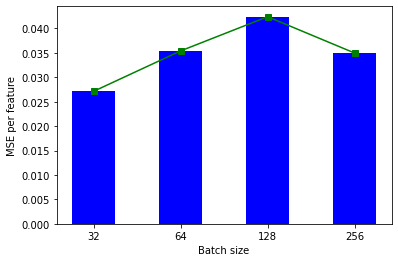

In [20]:
import matplotlib.pyplot as plt

sampled_loss = {}

log_freq = 200
for batch_size in [32,64,128,256]:
    sampled_loss[batch_size] = [sum(log_credit_dsa_dropout[batch_size][:,2][i*log_freq:(i+1)*log_freq])/log_freq for i in range(int(len(log_credit_dsa_dropout[batch_size][:,0])/log_freq))]

x = ["32", '64', '128', '256']
y = [sampled_loss[i][-1] for i in [32,64,128,256]]
plt.xlabel("Batch size")
plt.ylabel("MSE per feature")
plt.bar(x, y, color='b', width=0.5)
plt.plot(x,y,'gs-')
plt.savefig("fig/dsa-batch-size.pdf", bbox_inches='tight')